### Introduction
Deciding whether a used car is worth the posted price when you see listings online can be difficult. Several factors,
including mileage, make, model, year, etc. can influence the actual worth of a car. From the perspective of a seller, it is also a dilemma to price a used car appropriately. Based on existing data, the aim is to use machine learning algorithms to develop models for predicting used car prices.

###  Importing necessary Libraries

In [160]:
# !conda install -c conda-forge pycaret --yes
# !conda install -c conda-forge scikit-plot --yes

In [1]:
import pandas as pd #tabular data analysis and manipulation
import numpy as np #vectorization and array manipulation
import statsmodels.api as sm#statistical test
from scipy import stats #statistical test
from statsmodels.formula.api import ols #statistical test
import seaborn as sns #statistical data visualization
import matplotlib.pyplot as plt #statistical data visualization
from sklearn import preprocessing #utility to change raw feature vectors into representations, more suitable for downstream estimators.
from sklearn import impute #replace missing values
from sklearn import model_selection #create folds, tune hyperparameters, split data
from sklearn import linear_model #models where target is linearly dependent with the features
from sklearn import svm #support vector machines
from sklearn import tree # tree based algorithms
from sklearn import ensemble #Multiple trees based algorithms
# from pycaret.regression import * #data impute,data transformation, model fit, hyperparameter tuning
import warnings
warnings.filterwarnings('ignore')

In [2]:
# path defined for the train data and test data
train_path = './usedCarData/train.csv'
test_path = './usedCarData/test.csv'

In [3]:
# reading the train data file
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [4]:
#first five rows of train data
train_df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


### Preprocessing Data

In [5]:
#Organize the column names which will help us to call them in easy way
train_df.columns = ['ID', 'Price', 'Levy', 'Manufacturer', 'Model', 'ProdYear',
       'Category', 'LeatherInterior', 'FuelType', 'EngineVolume', 'Mileage',
       'Cylinders', 'GearBoxType', 'DriveWheels', 'Doors', 'Wheel', 'Color',
       'Airbags']

test_df.columns = ['ID', 'Levy', 'Manufacturer', 'Model', 'ProdYear',
       'Category', 'LeatherInterior', 'FuelType', 'EngineVolume', 'Mileage',
       'Cylinders', 'GearBoxType', 'DriveWheels', 'Doors', 'Wheel', 'Color',
       'Airbags', 'Price']

The data above provides us with attributes of a car like Manufacturer, manufatured year, Category, Odometer value which will help us to predict the price of the car. Let us check the percentage of missing rows for each feature in the data.

In [166]:
#percentage of missing values.Missing values may be present in some different forms
train_df.isna().mean()

ID                 0.0
Price              0.0
Levy               0.0
Manufacturer       0.0
Model              0.0
ProdYear           0.0
Category           0.0
LeatherInterior    0.0
FuelType           0.0
EngineVolume       0.0
Mileage            0.0
Cylinders          0.0
GearBoxType        0.0
DriveWheels        0.0
Doors              0.0
Wheel              0.0
Color              0.0
Airbags            0.0
dtype: float64

In [167]:
#selecting only object columns
#few numerical columns like Levy, Mileage, Doors are represented as object columns which we have to convert to numerical.
#Column Levy has hyphen as missing values, Mileage has km attached to it
train_df.select_dtypes('object').head()

,Levy,Manufacturer,Model,Category,LeatherInterior,FuelType,EngineVolume,Mileage,GearBoxType,DriveWheels,Doors,Wheel,Color
0,1399,LEXUS,RX 450,Jeep,Yes,Hybrid,3.5,186005 km,Automatic,4x4,04-May,Left wheel,Silver
1,1018,CHEVROLET,Equinox,Jeep,No,Petrol,3,192000 km,Tiptronic,4x4,04-May,Left wheel,Black
2,-,HONDA,FIT,Hatchback,No,Petrol,1.3,200000 km,Variator,Front,04-May,Right-hand drive,Black
3,862,FORD,Escape,Jeep,Yes,Hybrid,2.5,168966 km,Automatic,4x4,04-May,Left wheel,White
4,446,HONDA,FIT,Hatchback,Yes,Petrol,1.3,91901 km,Automatic,Front,04-May,Left wheel,Silver


In [6]:
train_df.Levy = train_df.Levy.replace('-',np.nan).astype('float') # converting hyphen to NaN and changing the column data type to float
train_df.Mileage = train_df.Mileage.replace(' km', '', regex=True).astype('int') # converting Mileage to integer data type

train_df['Turbo'] = np.where(train_df.EngineVolume.str.contains('Turbo'), 1,0) #creating column Turbo for Turbo engines

In [7]:
test_df.Levy = test_df.Levy.replace('-',np.nan).astype('float') # converting hyphen to NaN and changing the column data type to float
test_df.Mileage = test_df.Mileage.replace(' km', '', regex=True).astype('int') # converting Mileage to integer data type

test_df['Turbo'] = np.where(test_df.EngineVolume.str.contains('Turbo'), 1,0) #creating column Turbo for Turbo engines

In [169]:
#Lets check Engine Volume, Drive wheels and Doors
train_df.EngineVolume.unique() # engines are Turbo and normal

array(['3.5', '3', '1.3', '2.5', '2', '1.8', '2.4', '4', '1.6', '3.3',
       '2.0 Turbo', '2.2 Turbo', '4.7', '1.5', '4.4', '3.0 Turbo',
       '1.4 Turbo', '3.6', '2.3', '1.5 Turbo', '1.6 Turbo', '2.2',
       '2.3 Turbo', '1.4', '5.5', '2.8 Turbo', '3.2', '3.8', '4.6', '1.2',
       '5', '1.7', '2.9', '0.5', '1.8 Turbo', '2.4 Turbo', '3.5 Turbo',
       '1.9', '2.7', '4.8', '5.3', '0.4', '2.8', '3.2 Turbo', '1.1',
       '2.1', '0.7', '5.4', '1.3 Turbo', '3.7', '1', '2.5 Turbo', '2.6',
       '1.9 Turbo', '4.4 Turbo', '4.7 Turbo', '0.8', '0.2 Turbo', '5.7',
       '4.8 Turbo', '4.6 Turbo', '6.7', '6.2', '1.2 Turbo', '3.4',
       '1.7 Turbo', '6.3 Turbo', '2.7 Turbo', '4.3', '4.2', '2.9 Turbo',
       '0', '4.0 Turbo', '20', '3.6 Turbo', '0.3', '3.7 Turbo', '5.9',
       '5.5 Turbo', '0.2', '2.1 Turbo', '5.6', '6', '0.7 Turbo',
       '0.6 Turbo', '6.8', '4.5', '0.6', '7.3', '0.1', '1.0 Turbo', '6.3',
       '4.5 Turbo', '0.8 Turbo', '4.2 Turbo', '3.1', '5.0 Turbo', '6.4',
       '3

In [8]:
#Removing Turbo from the Engine Volume
train_df.EngineVolume = train_df.EngineVolume.replace(' Turbo','', regex=True).astype('float')

test_df.EngineVolume = test_df.EngineVolume.replace(' Turbo','', regex=True).astype('float')

In [9]:
train_df.DriveWheels.unique() #Three drive wheels

array(['4x4', 'Front', 'Rear'], dtype=object)

In [10]:
train_df.Doors.unique() # Three kinds of Doors. Some cleaning is needed here.

array(['04-May', '02-Mar', '>5'], dtype=object)

In [11]:
train_df.Doors = train_df.Doors.replace(r'-[a-zA-Z]{3}','',regex=True)# using regex to clean Doors

test_df.Doors = test_df.Doors.replace(r'-[a-zA-Z]{3}','',regex=True)# using regex to clean Doors

In [12]:
train_df.Doors.unique(), test_df.Doors.unique() #unique doors

(array(['04', '02', '>5'], dtype=object),
 array(['02', '04', '>5'], dtype=object))

In [17]:
# lets look at the non-object columns, Mileage and levy are now numerical columns
train_df[train_df.select_dtypes(exclude='object').columns].head()

,Price,Levy,ProdYear,EngineVolume,Mileage,Cylinders,Airbags,Turbo
0,13328,1399.0,2010,3.5,186005,6.0,12,0
1,16621,1018.0,2011,3.0,192000,6.0,8,0
2,8467,NaN,2006,1.3,200000,4.0,2,0
3,3607,862.0,2011,2.5,168966,4.0,0,0
4,11726,446.0,2014,1.3,91901,4.0,4,0


In [ ]:
#drop the ID column
train_df.drop('ID', axis =1, inplace=True)
test_df.drop('ID', axis=1, inplace=True)

In [18]:
#Check for duplicates, 3512 duplicate rows are present, we can drop them by keeping one of them
train_df[train_df.duplicated()].shape

(3512, 18)

In [19]:
train_df.drop_duplicates(keep='first', inplace=True) # removing duplicates

In [22]:
#check the percentage of missing values
train_df.isna().mean()

Price              0.000000
Levy               0.361463
Manufacturer       0.000000
Model              0.000000
ProdYear           0.000000
Category           0.000000
LeatherInterior    0.000000
FuelType           0.000000
EngineVolume       0.000000
Mileage            0.000000
Cylinders          0.000000
GearBoxType        0.000000
DriveWheels        0.000000
Doors              0.000000
Wheel              0.000000
Color              0.000000
Airbags            0.000000
Turbo              0.000000
dtype: float64

* 36% of the levy data is missing

In [180]:
train_df.head()

,Price,Levy,Manufacturer,Model,ProdYear,Category,LeatherInterior,FuelType,EngineVolume,Mileage,Cylinders,GearBoxType,DriveWheels,Doors,Wheel,Color,Airbags,Turbo
0,13328,1399.0,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005,6.0,Automatic,4x4,04,Left wheel,Silver,12,0
1,16621,1018.0,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000,6.0,Tiptronic,4x4,04,Left wheel,Black,8,0
2,8467,NaN,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000,4.0,Variator,Front,04,Right-hand drive,Black,2,0
3,3607,862.0,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966,4.0,Automatic,4x4,04,Left wheel,White,0,0
4,11726,446.0,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901,4.0,Automatic,Front,04,Left wheel,Silver,4,0


In [181]:
# since we did not reset the index, we can see that initially there were 19,237 entries and after removing duplicates
# there are 15725
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15725 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Price            15725 non-null  int64  
 1   Levy             10041 non-null  float64
 2   Manufacturer     15725 non-null  object 
 3   Model            15725 non-null  object 
 4   ProdYear         15725 non-null  int64  
 5   Category         15725 non-null  object 
 6   LeatherInterior  15725 non-null  object 
 7   FuelType         15725 non-null  object 
 8   EngineVolume     15725 non-null  float64
 9   Mileage          15725 non-null  int64  
 10  Cylinders        15725 non-null  float64
 11  GearBoxType      15725 non-null  object 
 12  DriveWheels      15725 non-null  object 
 13  Doors            15725 non-null  object 
 14  Wheel            15725 non-null  object 
 15  Color            15725 non-null  object 
 16  Airbags          15725 non-null  int64  
 17  Turbo       

**Check the Outliers**

In [23]:
#Convert the year column to age and check the outliers

train_df.ProdYear = 2021 - train_df.ProdYear

test_df.ProdYear = 2021 - test_df.ProdYear

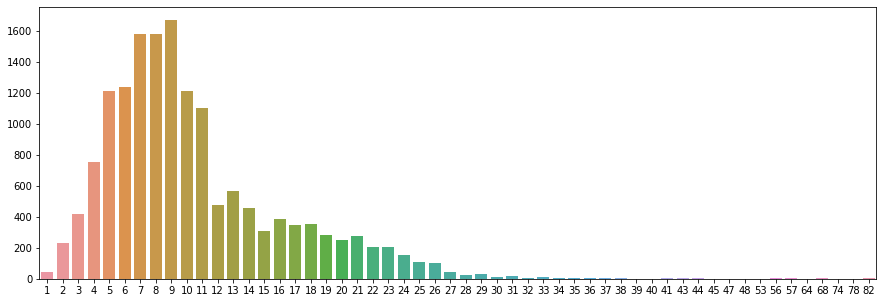

In [183]:
plt.figure(figsize=(15,5))
sns.barplot(train_df.ProdYear.value_counts().index,train_df.ProdYear.value_counts().values);

In [184]:
train_df.ProdYear.quantile([0.01, 0.99])

0.01     2.0
0.99    27.0
Name: ProdYear, dtype: float64

From the above graph we can see that cars above age 30 dont make a big contribution, also cars with age<=27 constitues more
tha 99% of tha data.

In [185]:
train_df = train_df[train_df.ProdYear<=30]

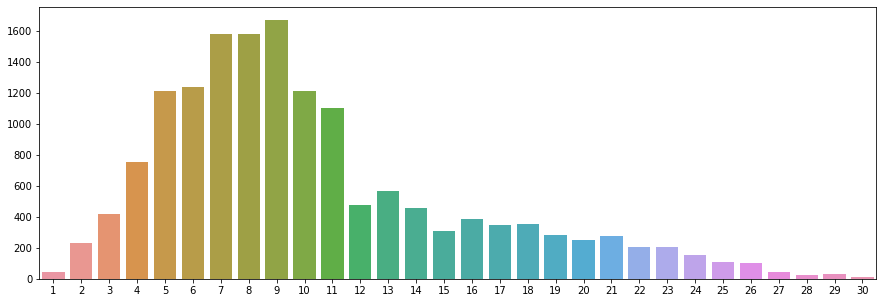

In [186]:
#after removing outliers
plt.figure(figsize=(15,5))
sns.barplot(train_df.ProdYear.value_counts().index,train_df.ProdYear.value_counts().values);

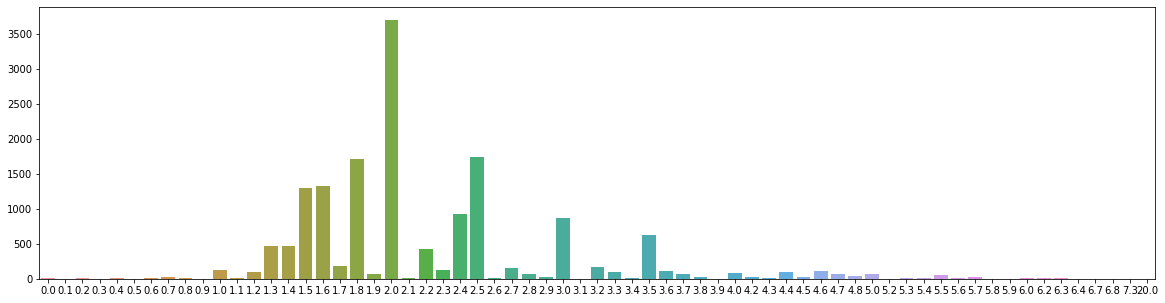

In [187]:
#Checking outliers in Engine volume
plt.figure(figsize=(20,5))
sns.barplot(train_df.EngineVolume.value_counts().index,train_df.EngineVolume.value_counts().values);

Lot of Engine Volume are present which are very less in numbers, lets check the count of each engine

In [188]:
# collecting engines with count less than or equal to 10
engineCount = pd.DataFrame(train_df.EngineVolume.value_counts()).reset_index()
engineCount.columns = ['Engine','Count']
dropEngine = engineCount[engineCount.Count<=10]['Engine'].values
dropEngine

array([ 2.1,  6.2,  0. ,  0.2,  5.3,  3.4,  1.1,  0.8,  5.4,  0.4,  6.3,
        5.6,  6. ,  0.6,  0.1,  5.9,  6.4,  3.9,  6.7,  5.2,  0.3,  0.9,
        6.8,  3.1,  7.3,  0.5, 20. ,  5.8])

In [189]:
# droppping the engine
train_df = train_df[~train_df.EngineVolume.isin(dropEngine)]

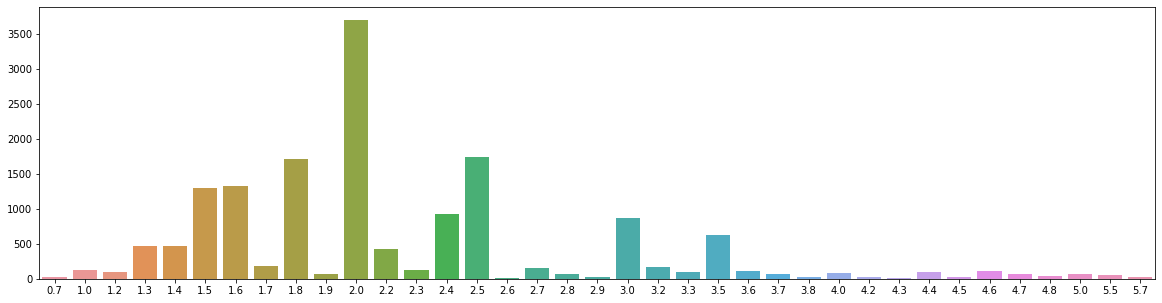

In [190]:
#after dropping the outliers from engine volume
plt.figure(figsize=(20,5))
sns.barplot(train_df.EngineVolume.value_counts().index,train_df.EngineVolume.value_counts().values);

In [191]:
# In category it seems better to combine Pickup, Cabriolet and Limousine
train_df.Category.value_counts()

Sedan          6924
Jeep           4172
Hatchback      2530
Minivan         531
Coupe           456
Universal       307
Microbus        287
Goods wagon     227
Pickup           49
Cabriolet        31
Limousine         5
Name: Category, dtype: int64

In [24]:
#Combine all three categories to PCL category
train_df.Category = train_df.Category.apply(lambda x: 'PCL' if x in ('Pickup','Cabriolet','Limousine') else x)

test_df.Category = test_df.Category.apply(lambda x: 'PCL' if x in ('Pickup','Cabriolet','Limousine') else x)
train_df.Category.value_counts()

Sedan          7010
Jeep           4225
Hatchback      2548
Minivan         534
Coupe           476
Universal       311
Microbus        295
Goods wagon     229
PCL              97
Name: Category, dtype: int64

In [26]:
#We can apply the same procedure which we applied to the Engine Volume. Remove count less than a threshold value
train_df.Manufacturer.value_counts().tail()

TESLA           1
PONTIAC         1
SATURN          1
ASTON MARTIN    1
GREATWALL       1
Name: Manufacturer, dtype: int64

In [194]:
#manufacturers with count less than or equal to 10
manufacturerCount = pd.DataFrame(train_df.Manufacturer.value_counts()).reset_index()
manufacturerCount.columns = ['Manufacturer','Count']
dropManufacturer= manufacturerCount[manufacturerCount.Count<=10]['Manufacturer'].values
dropManufacturer

array(['LINCOLN', 'GMC', 'CITROEN', 'SCION', 'GAZ', 'ISUZU', 'MASERATI',
       'MERCURY', 'ALFA ROMEO', 'UAZ', 'ROVER', 'HUMMER', 'სხვა', 'SEAT',
       'SAAB', 'HAVAL', 'LANCIA', 'BENTLEY', 'FERRARI', 'LAMBORGHINI',
       'PONTIAC', 'SATURN', 'ASTON MARTIN', 'GREATWALL'], dtype=object)

In [195]:
train_df = train_df[~train_df.Manufacturer.isin(dropManufacturer)]

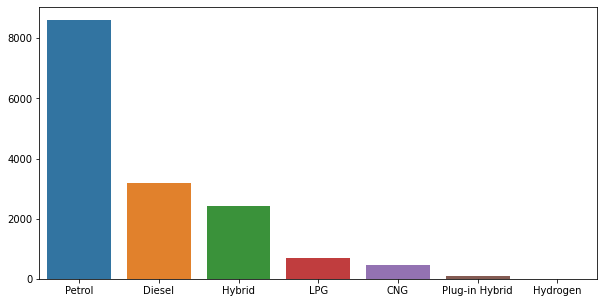

In [196]:
#Fuel type
#We can combine hybrid and PlugIn Hybris. another group can be made of LPG, CNG and Hydrogen
plt.figure(figsize=(10,5))
sns.barplot(train_df.FuelType.value_counts().index, train_df.FuelType.value_counts().values);

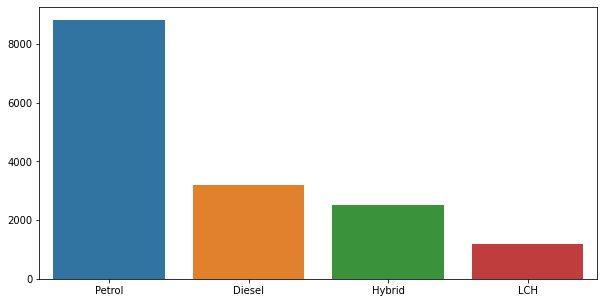

In [27]:
#After grouping the fuel Types
train_df.FuelType = train_df.FuelType.apply(lambda x: 'Hybrid' if x=='Plug-in Hybrid' else x)
train_df.FuelType = train_df.FuelType.apply(lambda x: 'LCH' if x in ('LPG','CNG','Hydrogen') else x)

test_df.FuelType = test_df.FuelType.apply(lambda x: 'Hybrid' if x=='Plug-in Hybrid' else x)
test_df.FuelType = test_df.FuelType.apply(lambda x: 'LCH' if x in ('LPG','CNG','Hydrogen') else x)

plt.figure(figsize=(10,5))
sns.barplot(train_df.FuelType.value_counts().index, train_df.FuelType.value_counts().values);

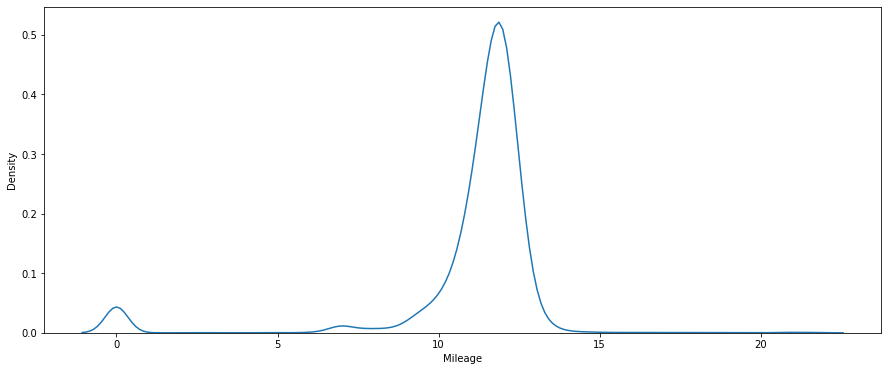

In [28]:
#log transformation of Mileage
plt.figure(figsize=(15,6))
sns.kdeplot(np.log1p(train_df.Mileage));

In [199]:
#check the outliers of Mileage, Removing Mileage greater than or equal to 576972
train_df.Mileage.quantile([0.01, 0.99])

0.01         0.00
0.99    576887.24
Name: Mileage, dtype: float64

In [200]:
#After removing  outliers from Mileage
train_df = train_df[train_df.Mileage<576972]
train_df.shape

(15283, 18)

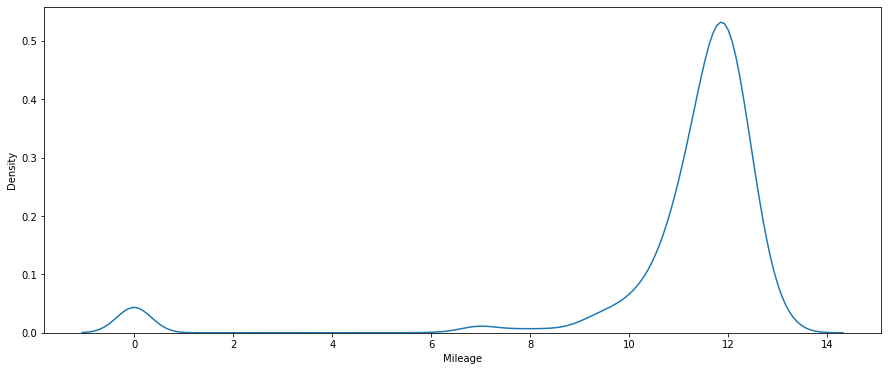

In [201]:
#log transformation of Mileage after removing outliers from the right end
#We msut trat 0 values of Mileage column before removing outliers from the left end, else we will lose data
plt.figure(figsize=(15,6))
sns.kdeplot(np.log1p(train_df.Mileage));

In [29]:
#Mileage is correlated with ProdYear, we can use ProdYear column to impute the 0 values in Mileaage
# Also cylinders and engine volume are higly correlated, and since engline volume is correlated more with price
train_df[['Mileage','ProdYear','Price','Levy','EngineVolume','Cylinders']].corr()

,Mileage,ProdYear,Price,Levy,EngineVolume,Cylinders
Mileage,1.000000,0.064121,-0.002011,0.027984,-0.003983,0.000580
ProdYear,0.064121,1.000000,-0.014836,0.226092,0.066206,0.124283
Price,-0.002011,-0.014836,1.000000,0.081075,0.013910,0.010546
Levy,0.027984,0.226092,0.081075,1.000000,0.579051,0.496426
EngineVolume,-0.003983,0.066206,0.013910,0.579051,1.000000,0.731923
Cylinders,0.000580,0.124283,0.010546,0.496426,0.731923,1.000000


In [30]:
#replacing 0 with nan
train_df.Mileage = train_df.Mileage.replace(0, np.nan)

test_df.Mileage = test_df.Mileage.replace(0, np.nan)

In [39]:
#aggregating ProdYear and car category to find median price and filling nan values of mileage
train_df.Mileage = train_df.Mileage.fillna(train_df.groupby(['ProdYear','Category'])['Price'].transform('median'))

test_df.Mileage = test_df.Mileage.fillna(train_df.groupby(['ProdYear','Category'])['Price'].transform('median'))

In [205]:
#Checkin the quantile to remove the outliers from the left end
train_df.Mileage.quantile([0.02,0.99])

0.02      4547.50
0.99    418835.48
Name: Mileage, dtype: float64

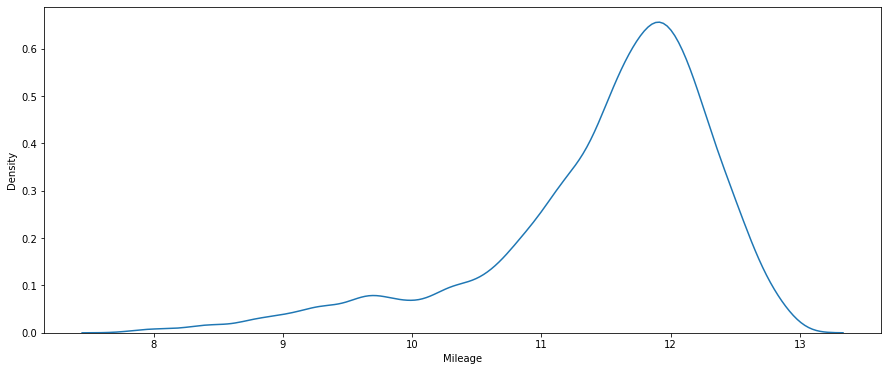

In [206]:
#removing outliers
train_df = train_df[(train_df.Mileage>=2500) & (train_df.Mileage<=418835)]

plt.figure(figsize=(15,6))
sns.kdeplot(np.log1p(train_df.Mileage));

In [208]:
#Cylinders, Group together cylinders values less than or equal to 161
train_df.Cylinders.value_counts()

4.0     11723
6.0      2303
8.0       529
5.0       156
3.0        96
2.0        35
12.0       31
1.0        25
10.0       12
16.0        5
7.0         3
9.0         1
14.0        1
Name: Cylinders, dtype: int64

In [32]:
#Grouping ess occuring cylinder values into other category
train_df.Cylinders = train_df.Cylinders.apply(lambda x: 'other' if x in (3.0,2.0,12.0,1.0,10.0,
                                                                            16.0,7.0,9.0,14.0) else x)

test_df.Cylinders = test_df.Cylinders.apply(lambda x: 'other' if x in (3.0,2.0,12.0,1.0,10.0,
                                                                            16.0,7.0,9.0,14.0) else x)

train_df.Cylinders.value_counts()

4.0      12279
6.0       2429
8.0        605
other      247
5.0        165
Name: Cylinders, dtype: int64

In [212]:
#Distribution of GearBox Type
train_df.GearBoxType.value_counts()

Automatic    9661
Tiptronic    2961
Manual       1585
Variator      713
Name: GearBoxType, dtype: int64

In [213]:
#Distribution of drive wheels
train_df.DriveWheels.value_counts()

Front    10532
4x4       2620
Rear      1768
Name: DriveWheels, dtype: int64

In [214]:
train_df.Doors.value_counts()

04    14149
02      655
>5      116
Name: Doors, dtype: int64

In [33]:
#Drop the column Levy
train_df = train_df.drop('Levy', axis=1)

test_df = test_df.drop('Levy', axis=1)

In [219]:
train_df.head()

,Price,Manufacturer,Model,ProdYear,Category,LeatherInterior,FuelType,EngineVolume,Mileage,Cylinders,GearBoxType,DriveWheels,Doors,Wheel,Color,Airbags,Turbo
0,13328,LEXUS,RX 450,11,Jeep,Yes,Hybrid,3.5,186005.0,6.0,Automatic,4x4,04,Left wheel,Silver,12,0
1,16621,CHEVROLET,Equinox,10,Jeep,No,Petrol,3.0,192000.0,6.0,Tiptronic,4x4,04,Left wheel,Black,8,0
2,8467,HONDA,FIT,15,Hatchback,No,Petrol,1.3,200000.0,4.0,Variator,Front,04,Right-hand drive,Black,2,0
3,3607,FORD,Escape,10,Jeep,Yes,Hybrid,2.5,168966.0,4.0,Automatic,4x4,04,Left wheel,White,0,0
4,11726,HONDA,FIT,7,Hatchback,Yes,Petrol,1.3,91901.0,4.0,Automatic,Front,04,Left wheel,Silver,4,0


In [42]:
test_df.head()

,Manufacturer,Model,ProdYear,Category,LeatherInterior,FuelType,EngineVolume,Mileage,Cylinders,GearBoxType,DriveWheels,Doors,Wheel,Color,Airbags,Turbo
0,VOLKSWAGEN,Golf,9,Hatchback,No,Diesel,2.0,19578.5,4,Manual,Front,02,Left wheel,Grey,10,1
1,HYUNDAI,Sonata,9,Sedan,Yes,Petrol,2.4,26000.0,4,Tiptronic,Front,04,Left wheel,Grey,10,0
2,NISSAN,Tiida,16,Sedan,No,Petrol,1.5,168000.0,4,Automatic,Front,04,Right-hand drive,Sky blue,8,0
3,VOLVO,XC90,9,Jeep,Yes,Petrol,3.2,143000.0,6,Automatic,4x4,04,Left wheel,Blue,12,0
4,OPEL,Astra,28,Hatchback,No,Petrol,1.6,200000.0,4,Manual,Front,04,Left wheel,Black,0,0


In [41]:
test_df = test_df.drop('ID', axis=1)
test_df = test_df.drop('Price', axis=1)

**Exploratory Data Analysis**

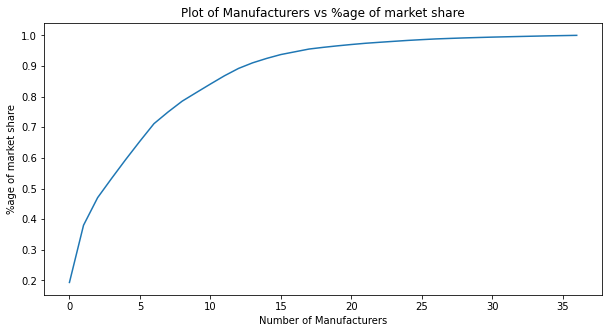

HYUNDAI          0.193566
TOYOTA           0.380228
MERCEDES-BENZ    0.470241
CHEVROLET        0.533579
FORD             0.595174
BMW              0.654491
HONDA            0.711796
NISSAN           0.749933
VOLKSWAGEN       0.785188
LEXUS            0.813204
SSANGYONG        0.840952
KIA              0.868029
OPEL             0.892091
MITSUBISHI       0.910322
SUBARU           0.924799
AUDI             0.937332
JEEP             0.946314
MAZDA            0.955295
DODGE            0.960791
FIAT             0.965684
Name: Manufacturer, dtype: float64


In [220]:
#Let us check the market share of car manufacturers
y = train_df.Manufacturer.value_counts(normalize=True).cumsum()
x = len(y)
plt.figure(figsize=(10,5))
plt.plot(range(x),y);
plt.title('Plot of Manufacturers vs %age of market share')
plt.xlabel('Number of Manufacturers')
plt.ylabel('%age of market share')
plt.show()
print(y.head(20))

* 20 manufacturers hold more than 96% of the market share according to the train data

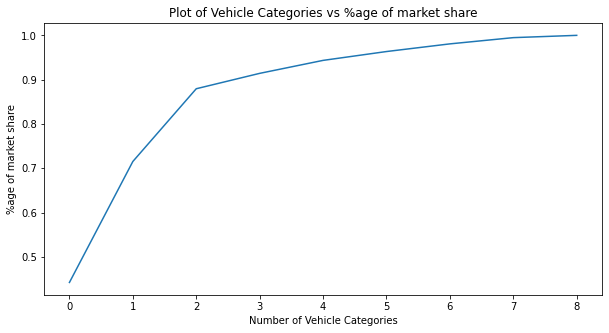

Sedan          0.442225
Jeep           0.715282
Hatchback      0.879491
Minivan        0.914209
Coupe          0.943499
Universal      0.963472
Microbus       0.980764
Goods wagon    0.994839
PCL            1.000000
Name: Category, dtype: float64


In [221]:
#Lets do the same analysis for vehicle categories
y = train_df.Category.value_counts(normalize=True).cumsum()
x = len(y)
plt.figure(figsize=(10,5))
plt.plot(range(x),y);
plt.title('Plot of Vehicle Categories vs %age of market share')
plt.xlabel('Number of Vehicle Categories')
plt.ylabel('%age of market share')
plt.show()
print(y.head(20))

* From above we can see that Sedan, Jeep, Hatchback, Minivan and Coupe hold 95% of market

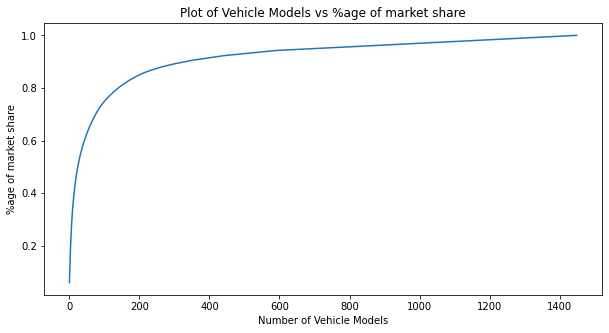

In [222]:
#Lets do the same analysis for vehicle models
y = train_df.Model.value_counts(normalize=True).cumsum()
x = len(y)
plt.figure(figsize=(10,5))
plt.plot(range(x),y);
plt.title('Plot of Vehicle Models vs %age of market share')
plt.xlabel('Number of Vehicle Models')
plt.ylabel('%age of market share')
plt.show()

In [223]:
print(y.head())

Prius       0.060858
Elantra     0.108579
Sonata      0.153753
Camry       0.192426
Santa FE    0.224732
Name: Model, dtype: float64


In [230]:
#before and after transformation plots
def plots(df, var, t):
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    sns.kdeplot(df[var])
    plt.title('before ' + str(t).split('(')[0])
    
    plt.subplot(122)
    p1 = t.fit_transform(df[[var]]).flatten()
    sns.kdeplot(p1)
    plt.title('after ' + str(t).split('(')[0])

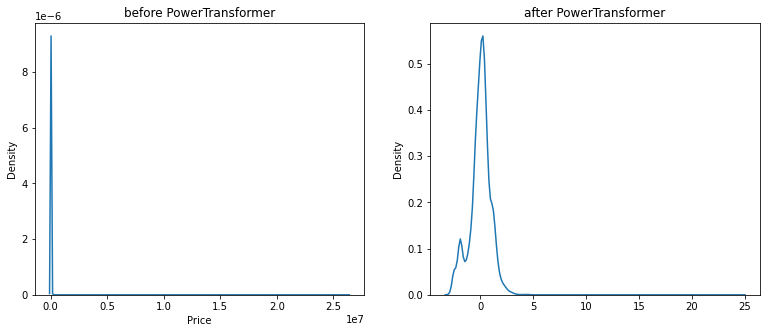

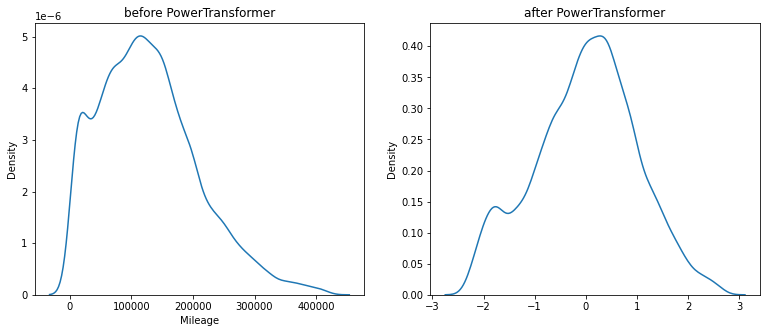

In [231]:
#Using power Transformer
columns = ['Price','Mileage']
for col in columns:
    plots(train_df, col, preprocessing.PowerTransformer(method='yeo-johnson'))

From the above graphs it can be inferred that power transformer will work best with Mileage and log transform will work
best with Price

* Lets look at different distributions of categorical features with respect to the target variables

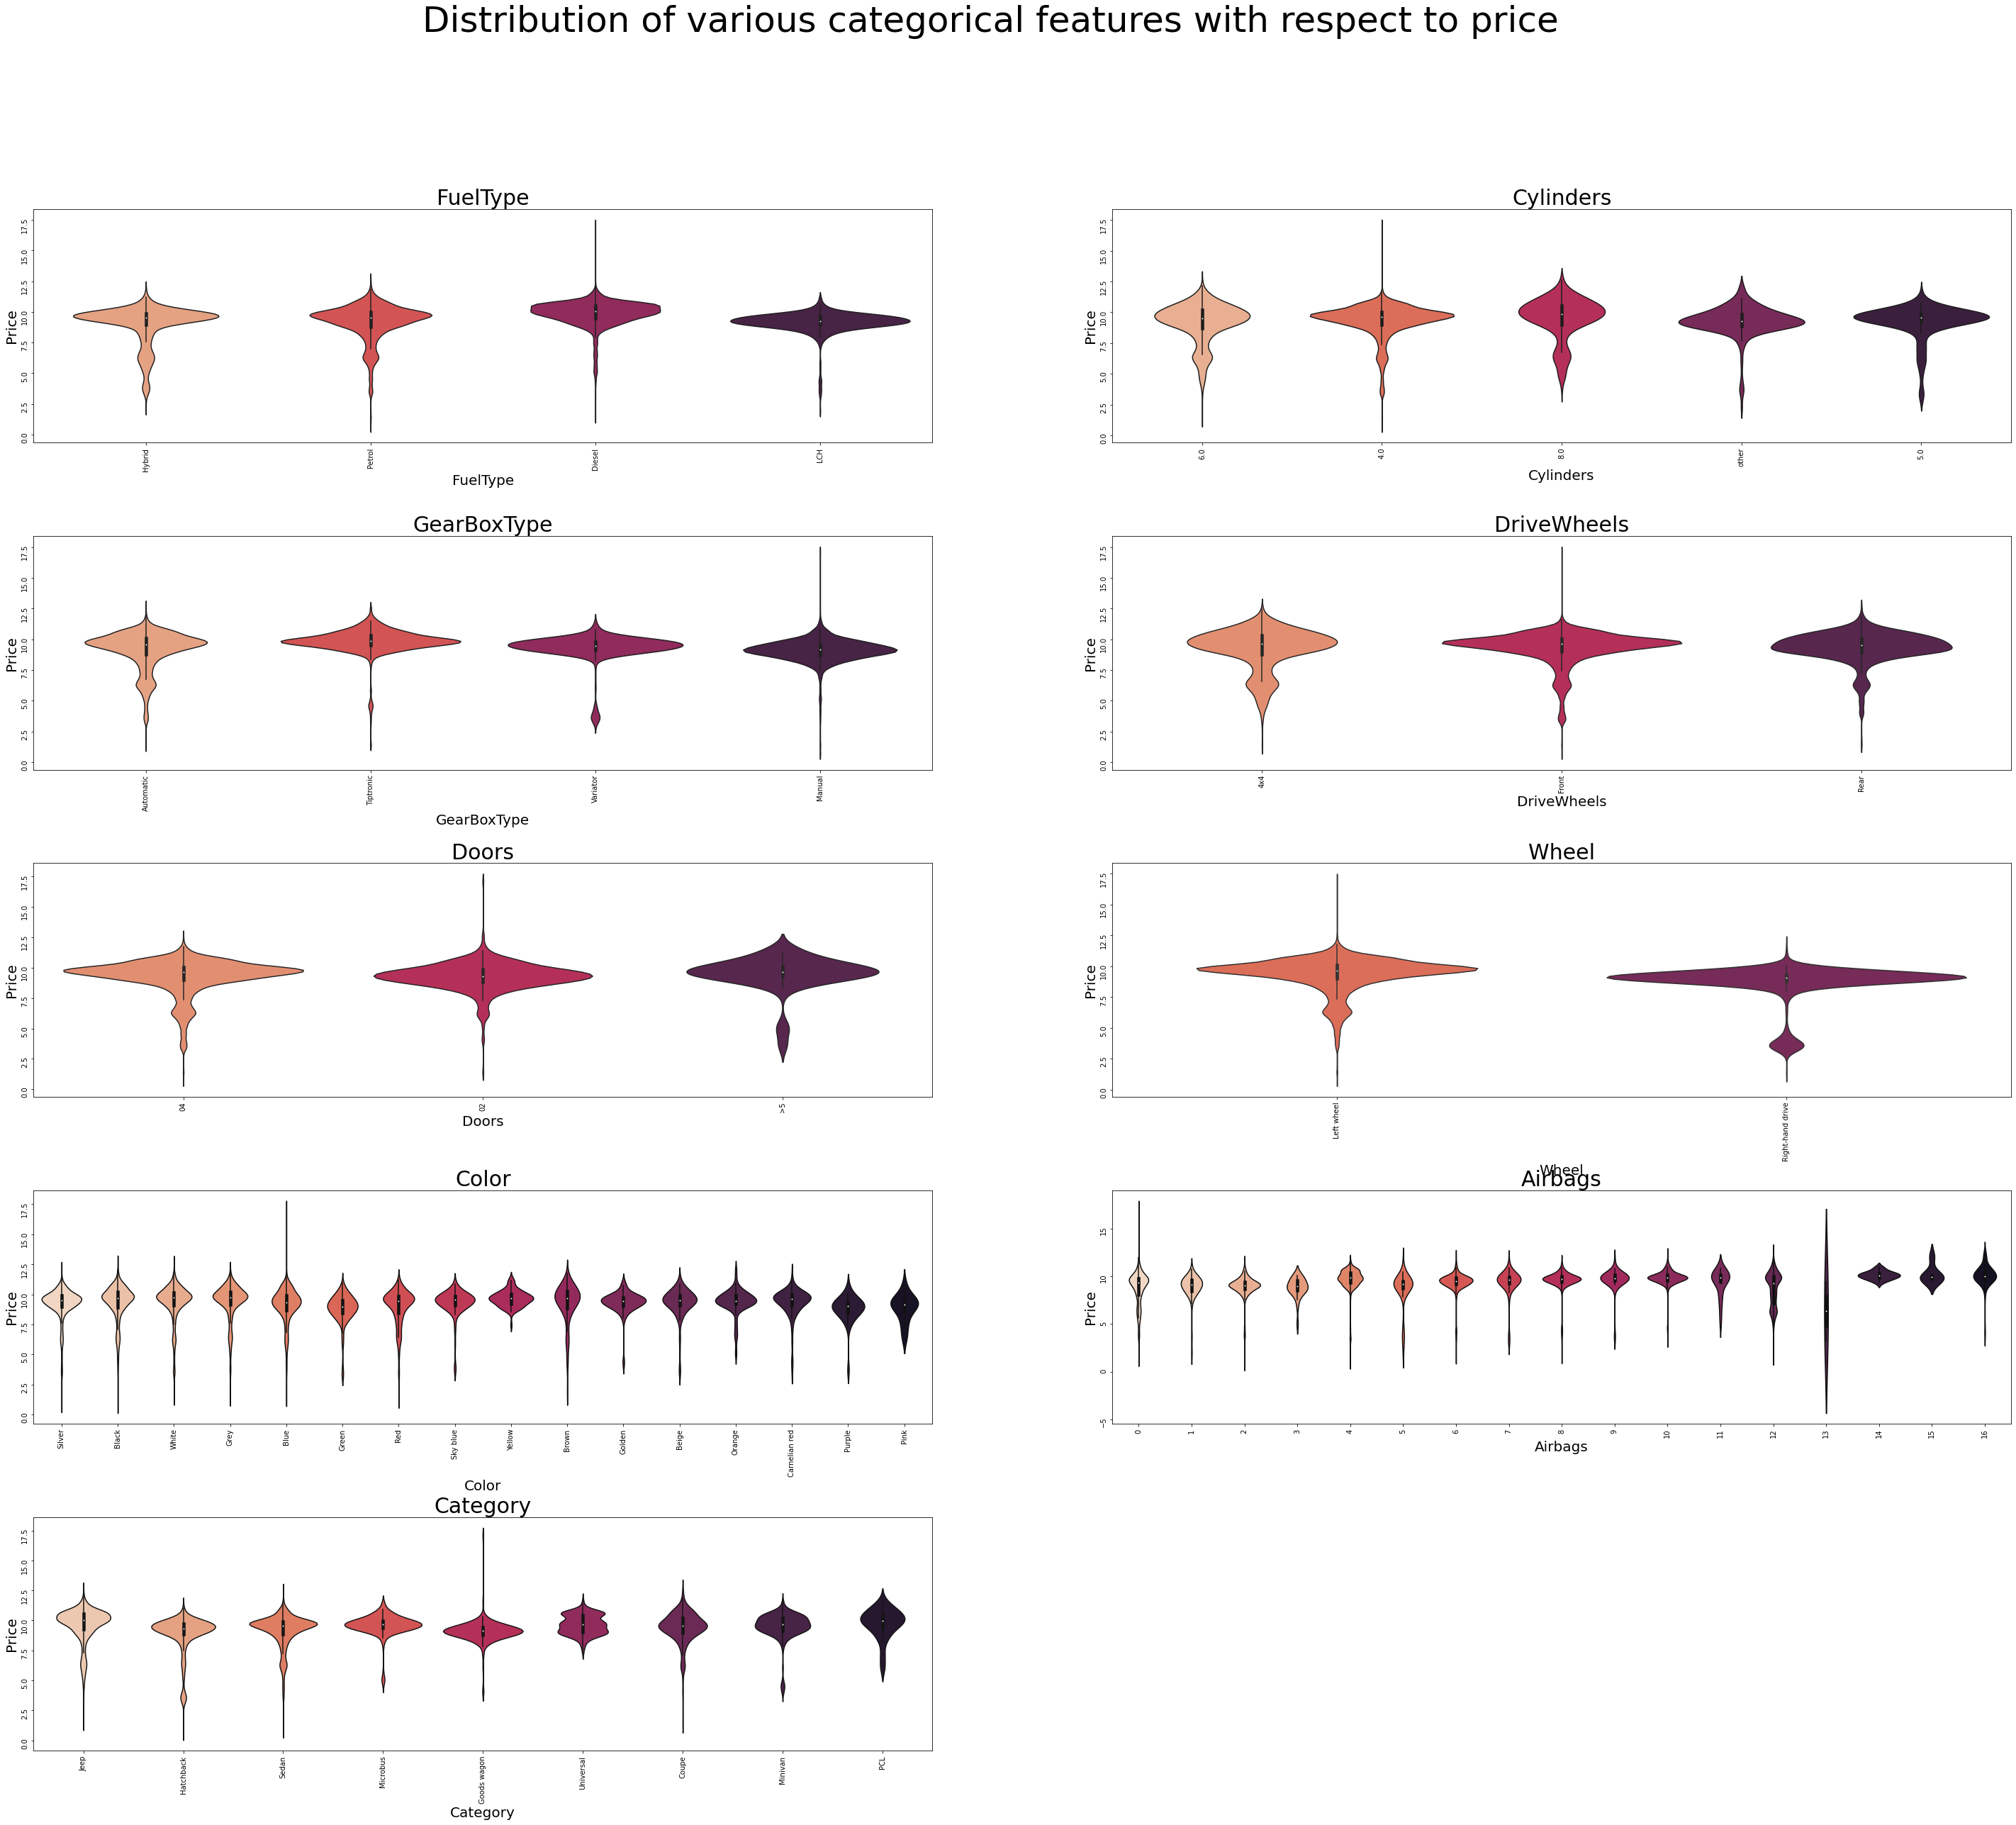

In [232]:
cat_cols = ['FuelType','Cylinders','GearBoxType',
            'DriveWheels','Doors','Wheel','Color', 'Airbags', 'Category']
fig,axes = plt.subplots(5,2,figsize=(50,40))
fig.subplots_adjust(wspace=0.2, hspace=0.4)
fig.suptitle('Distribution of various categorical features with respect to price', fontsize=50)
axes = axes.ravel()

#plotting bar charts of value counts by sorting the index of value_counts series
for i, col in enumerate(cat_cols):
    sns.violinplot(ax=axes[i], data=train_df, y=np.log1p(train_df.Price), x=train_df[col], palette='rocket_r')
    axes[i].set_title(col, fontsize=30)
    axes[i].xaxis.get_label().set_fontsize(20)
    axes[i].yaxis.get_label().set_fontsize(20)
    axes[i].tick_params(labelrotation=90)
fig.delaxes(axes[-1])

* Violin plots show us the same information as box plots and more. They also show us the ditribution of various values of a categorical features with the target variable.

* Lets perform some statistical test - ANOVA Analysis to check if there is a variability in features w.r.t to log of price.
* The null hypothesis says that there is no variability and the alternate hypothesis says that there is a variability. With 95% confidence level if p-value is less than 0.05 we can sat that null hypothesis doesnot hold true.

In [233]:
cols = ['Manufacturer','Model','ProdYear','FuelType','Cylinders','GearBoxType','EngineVolume',
            'DriveWheels','Doors','Wheel','Color', 'Airbags', 'Category']

# t-test and anova assumes data to normally distributed

tmp = train_df[cols].copy()

y = train_df.Price.apply(np.log) # log of price

for col in cols:
    cat_y = []
    for cat in tmp[col].unique():
        cat_y.append(y[tmp[col]==cat])
    print(f'{col}:\n{stats.f_oneway(*cat_y)}') #one-way ANOVA test

Manufacturer:
F_onewayResult(statistic=27.79526234807372, pvalue=3.874732948866846e-180)
Model:
F_onewayResult(statistic=2.4727795909793575, pvalue=6.721483920692061e-151)
ProdYear:
F_onewayResult(statistic=25.067351855009164, pvalue=6.638822240288141e-131)
FuelType:
F_onewayResult(statistic=238.0009351024877, pvalue=7.447944703009477e-151)
Cylinders:
F_onewayResult(statistic=7.074912669748329, pvalue=1.097160759359157e-05)
GearBoxType:
F_onewayResult(statistic=196.37834217439746, pvalue=6.488312293784688e-125)
EngineVolume:
F_onewayResult(statistic=19.93100360666316, pvalue=2.485839722961084e-124)
DriveWheels:
F_onewayResult(statistic=4.340213410913674, pvalue=0.013050209615593696)
Doors:
F_onewayResult(statistic=0.9885474284007567, pvalue=0.37214120131665673)
Wheel:
F_onewayResult(statistic=301.6547086522101, pvalue=6.532555121513158e-67)
Color:
F_onewayResult(statistic=7.228141818062422, pvalue=3.769914682464332e-16)
Airbags:
F_onewayResult(statistic=110.51810608538543, pvalue=0.0)


* The more the F-statistic the less is the p-value and we can say that there is definitely variability in the means of the features. From the above it can be seen that doors and drive wheels have very high p values and very low F-statistic which shows that these two features doesn't have high variability to explain the target variable Price.

In [43]:
#exporting the cleaned and process training data for building mdel and inferencing
train_df.to_csv('./usedCarData/clean_data.csv', index=False)
test_df.to_csv('./usedCarData/clean_test.csv', index=False)